In [1]:
import pandas as pd
import re
from transformers import BertTokenizer, BertForSequenceClassification
import torch
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import make_interp_spline, BSpline
import nltk


In [2]:
cases = pd.read_csv("justice.csv")
print(cases.isna().sum())
cases.dropna(inplace=True)
print(cases.isna().sum())
cases.head()

Unnamed: 0              0
ID                      0
name                    0
href                    0
docket                  0
term                    0
first_party             1
second_party            1
facts                   0
facts_len               0
majority_vote           0
minority_vote           0
first_party_winner     15
decision_type           7
disposition            72
issue_area            142
dtype: int64
Unnamed: 0            0
ID                    0
name                  0
href                  0
docket                0
term                  0
first_party           0
second_party          0
facts                 0
facts_len             0
majority_vote         0
minority_vote         0
first_party_winner    0
decision_type         0
disposition           0
issue_area            0
dtype: int64


,Unnamed: 0,ID,name,href,docket,term,first_party,second_party,facts,facts_len,majority_vote,minority_vote,first_party_winner,decision_type,disposition,issue_area
1,1,50613,Stanley v. Illinois,https://api.oyez.org/cases/1971/70-5014,70-5014,1971,"Peter Stanley, Sr.",Illinois,<p>Joan Stanley had three children with Peter ...,757,5,2,True,majority opinion,reversed/remanded,Civil Rights
2,2,50623,Giglio v. United States,https://api.oyez.org/cases/1971/70-29,70-29,1971,John Giglio,United States,<p>John Giglio was convicted of passing forged...,495,7,0,True,majority opinion,reversed/remanded,Due Process
3,3,50632,Reed v. Reed,https://api.oyez.org/cases/1971/70-4,70-4,1971,Sally Reed,Cecil Reed,"<p>The Idaho Probate Code specified that ""male...",378,7,0,True,majority opinion,reversed/remanded,Civil Rights
4,4,50643,Miller v. California,https://api.oyez.org/cases/1971/70-73,70-73,1971,Marvin Miller,California,"<p>Miller, after conducting a mass mailing cam...",305,5,4,True,majority opinion,vacated/remanded,First Amendment
5,5,50644,Kleindienst v. Mandel,https://api.oyez.org/cases/1971/71-16,71-16,1971,"Richard G. Kleindienst, Attorney General of th...","Ernest E. Mandel, et al.",<p>Ernest E. Mandel was a Belgian professional...,2282,6,3,True,majority opinion,reversed,First Amendment


In [3]:
max_idx = cases['facts_len'].idxmax()

# extract the text from the 'facts' column for the selected row
longest_facts = cases.loc[max_idx, 'facts']

print(longest_facts)
cases.drop(columns=['Unnamed: 0', 'ID', 'name', 'href', 'docket', 'term',  
                    'majority_vote', 'minority_vote', 'decision_type', 'disposition', 'issue_area'], inplace=True)



<p>Individual voters in Texas, along with organizations representing Latinos and African Americans, filed a number of lawsuits in 2011, challenging the Texas legislature’s congressional and state house redistricting plans. The actions were consolidated and proceed in the U.S. District Court for the Western District of Texas (“Texas District Court”). The plaintiffs alleged racial gerrymandering in violation of § 2 of the Voting Rights Act (VRA) as well as the 14th and 15th Amendments to the United States Constitution. At that time Texas was bound by the preclearance requirements under § 5 of the VRA, and therefore the State simultaneously filed an action in the U.S. District Court for the District of Columbia (“D.C. District Court”) seeking preclearance of the redistricting plans. </p>
<p>While trial proceedings were pending in both district courts, the 2012 primary elections were approaching. As a result, the Texas District Court assumed the task of implementing interim redistricting p

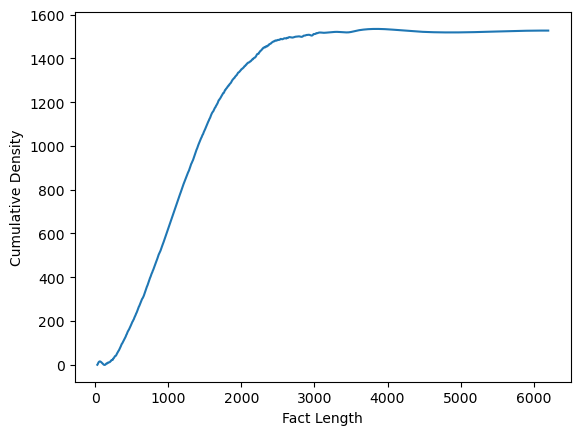

In [4]:
# Get the fact lengths
fact_lengths = cases['facts_len'].tolist()

# Assuming fact_lengths is a NumPy array or list of fact lengths
unique_lengths = np.unique(fact_lengths)

# Create a sorted array of unique fact lengths and their corresponding indices
sorted_lengths = np.sort(unique_lengths)
indices = np.arange(len(sorted_lengths))

# Interpolate the indices using a cubic spline
interp_func = make_interp_spline(sorted_lengths, indices, k=3)

# Generate a smooth curve by evaluating the interpolation function over a range of fact lengths
x = np.linspace(min(fact_lengths), max(fact_lengths), num=1000)
y = interp_func(x)

# Plot the curve using Matplotlib
import matplotlib.pyplot as plt
plt.plot(x, y)
plt.xlabel('Fact Length')
plt.ylabel('Cumulative Density')
plt.show()

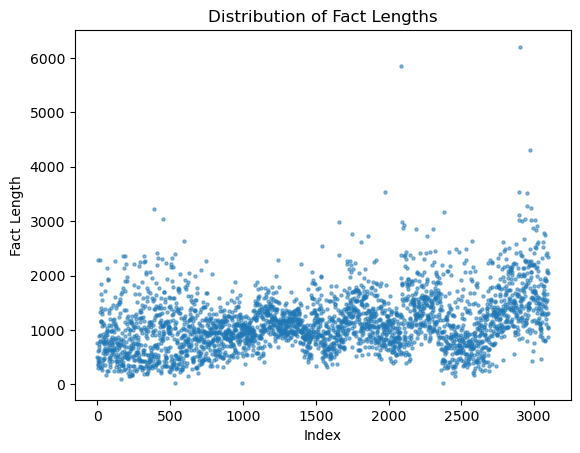

98.5474499677211


In [5]:
# Create a scatterplot of the fact lengths
plt.scatter(range(len(fact_lengths)), fact_lengths, s=5, alpha=0.5)

# Add labels and title
plt.xlabel('Index')
plt.ylabel('Fact Length')
plt.title('Distribution of Fact Lengths')

# Show the plot
plt.show()

# Count the number of facts below 2500 length
num_short_facts = len(cases[cases['facts_len'] < 2500])

# Calculate the percentage of short facts
percentage_short_facts = num_short_facts / len(cases) * 100
print(percentage_short_facts)

In [6]:
cases = cases.rename(columns={'first_party_winner': 'winning_party_idx'})
for i, row in cases.iterrows():
    if row['winning_party_idx'] == True:
        row['winning_party_idx'] = 0
    else:
        row['winning_party_idx'] = 1
cases

,first_party,second_party,facts,facts_len,winning_party_idx
1,"Peter Stanley, Sr.",Illinois,<p>Joan Stanley had three children with Peter ...,757,True
2,John Giglio,United States,<p>John Giglio was convicted of passing forged...,495,True
3,Sally Reed,Cecil Reed,"<p>The Idaho Probate Code specified that ""male...",378,True
4,Marvin Miller,California,"<p>Miller, after conducting a mass mailing cam...",305,True
5,"Richard G. Kleindienst, Attorney General of th...","Ernest E. Mandel, et al.",<p>Ernest E. Mandel was a Belgian professional...,2282,True
...,...,...,...,...,...
3297,"Janet L. Yellen, Secretary of the Treasury",Confederated Tribes of the Chehalis Reservatio...,<p>For over a century after the Alaska Purchas...,2340,True
3298,United States,Refugio Palomar-Santiago,"<p>Refugio Palomar-Santiago, a Mexican nationa...",2054,True
3299,Tarahrick Terry,United States,<p>Tarahrick Terry pleaded guilty to one count...,1027,False
3300,United States,Joshua James Cooley,<p>Joshua James Cooley was parked in his picku...,1309,True


In [7]:
cases['facts'] = cases['facts'].str.replace(r'<[^<]+?>', '', regex=True)
cases['facts'] = cases['facts'].str.lower().apply(lambda x: re.sub(r'[^a-z\s]', '', x)).apply(lambda x: ' '.join([word for word in x.split() if len(word) > 1]))
cases

,first_party,second_party,facts,facts_len,winning_party_idx
1,"Peter Stanley, Sr.",Illinois,joan stanley had three children with peter sta...,757,True
2,John Giglio,United States,john giglio was convicted of passing forged mo...,495,True
3,Sally Reed,Cecil Reed,the idaho probate code specified that males mu...,378,True
4,Marvin Miller,California,miller after conducting mass mailing campaign ...,305,True
5,"Richard G. Kleindienst, Attorney General of th...","Ernest E. Mandel, et al.",ernest mandel was belgian professional journal...,2282,True
...,...,...,...,...,...
3297,"Janet L. Yellen, Secretary of the Treasury",Confederated Tribes of the Chehalis Reservatio...,for over century after the alaska purchase in ...,2340,True
3298,United States,Refugio Palomar-Santiago,refugio palomarsantiago mexican national was g...,2054,True
3299,Tarahrick Terry,United States,tarahrick terry pleaded guilty to one count of...,1027,False
3300,United States,Joshua James Cooley,joshua james cooley was parked in his pickup t...,1309,True


In [8]:
cases['facts'].iloc[4]

'ernest mandel was belgian professional journalist and editorinchief of la guache belgian left socialist weekly publication he described himself as revolutionary marxist advocating the economic governmental and international doctrines of world communism previously the united states twice allowed mandel to temporarily visit the united states once as working journalist in and once as lecturer in both times and without mandels knowledge the state department found him ineligible but the attorney general used his discretionary power under the immigration and nationality act of to admit mendel temporarily the graduate student association at stanford university invited mandel to the united states for six days to participate in conference on september mandel applied to the american counsel in brussels for nonimmigrant visa to enter the united states other persons invited mandel to additional events and mandel filed second visa application in october detailing more extensive itinerary on octobe

use bert for classification
use sep token to include parties in case facts

tokenizer.sep_token

df.first_party + " [SEP] " + df.second_party + " [sep] " + 

bert for sequence classification 

gpt-2 simple 

In [9]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
cases['facts'] = cases.apply(lambda row: tokenizer(row['first_party'], row['second_party'], row['facts'],
                                                 padding='max_length', truncation=True, max_length=128,
                                                 return_tensors='pt').input_ids.squeeze(), axis=1)

In [10]:
cases['facts'].iloc[max_idx]

tensor([ 101, 2142, 2163,  102, 9122, 2508, 4658, 3240,  102,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0])

In [ ]:
# Load the pre-trained model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Set the device to use for the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define the input data and labels
inputs = torch.tensor(cases['text'].tolist())
labels = torch.tensor(cases['label'].tolist())

# Define the data loader
batch_size = 32
data = torch.utils.data.TensorDataset(inputs, labels)
data_loader = torch.utils.data.DataLoader(data, batch_size=batch_size)

# Set the model to evaluation mode
model.eval()

# Loop over the data loader and make predictions
with torch.no_grad():
    correct = 0
    total = 0
    for inputs, labels in data_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs[0], 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Print the accuracy
accuracy = 100 * correct / total
print('Accuracy: {:.2f}%'.format(accuracy))